In [4]:
# ============================================
# CELL 1: IMPORTS
# ============================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# ============================================
# CELL 2: LOAD DATA
# ============================================
df = pd.read_csv("data.csv")

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Original dataset shape: (20000, 27)
Columns: ['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous', 'Desired_Savings_Percentage', 'Desired_Savings', 'Disposable_Income', 'Potential_Savings_Groceries', 'Potential_Savings_Transport', 'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment', 'Potential_Savings_Utilities', 'Potential_Savings_Healthcare', 'Potential_Savings_Education', 'Potential_Savings_Miscellaneous']


In [6]:
# ============================================
# CELL 3: CREATE HARDER TARGETS (NEW LOGIC)
# ============================================

# Net income
df['Net_Income'] = df['Income'] - df['Rent'] - df['Loan_Repayment']

# Savings potential
df['Savings_Potential'] = (
    df['Net_Income'] -
    (df['Groceries'] + df['Transport'] + df['Utilities'] +
     df['Insurance'] + df['Healthcare'] + df['Education'])
) / df['Income']

# Add noise
np.random.seed(42)
noise = np.random.normal(0, 0.05, len(df))
df['Savings_Potential_Noisy'] = df['Savings_Potential'] + noise


def categorize_savings_capacity(value):
    if value >= 0.35:
        return 'high'
    elif value >= 0.18:
        return 'medium'
    else:
        return 'low'


df['Savings_Capacity'] = df['Savings_Potential_Noisy'].apply(categorize_savings_capacity)

# Risk score
df['Risk_Score'] = (
    (df['Age'] < 35) * 0.3 +
    (df['Loan_Repayment'] / (df['Income'] + 1) < 0.1) * 0.3 +
    ((df['Eating_Out'] + df['Entertainment']) / (df['Income'] + 1) > 0.12) * 0.4
)

# Add noise
noise_alloc = np.random.normal(0, 0.1, len(df))
df['Risk_Score_Noisy'] = df['Risk_Score'] + noise_alloc


def categorize_allocation(score):
    if score >= 0.6:
        return 'aggressive'
    elif score >= 0.3:
        return 'balanced'
    else:
        return 'conservative'


df['Allocation_Class'] = df['Risk_Score_Noisy'].apply(categorize_allocation)

print("\nSavings_Capacity distribution:")
print(df['Savings_Capacity'].value_counts())

print("\nAllocation_Class distribution:")
print(df['Allocation_Class'].value_counts())



Savings_Capacity distribution:
Savings_Capacity
high      10087
medium     8405
low        1508
Name: count, dtype: int64

Allocation_Class distribution:
Allocation_Class
conservative    9175
balanced        8154
aggressive      2671
Name: count, dtype: int64


In [7]:
# ============================================
# CELL 4: FEATURE SELECTION - ONLY BASE FEATURES
# ============================================
base_features = [
    'Income', 'Age', 'Dependents',
    'Occupation', 'City_Tier',
    'Rent', 'Loan_Repayment', 'Insurance',
    'Groceries', 'Transport', 'Eating_Out',
    'Entertainment', 'Utilities',
    'Healthcare', 'Education', 'Miscellaneous'
]

X = df[base_features].copy()
y_savings = df['Savings_Capacity'].copy()
y_allocation = df['Allocation_Class'].copy()

print(f"\n✓ Using ONLY {len(base_features)} base features")
print(base_features)



✓ Using ONLY 16 base features
['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous']


In [8]:
# ============================================
# CELL 4.5: LABEL ENCODE TARGETS (XGBOOST FIX)
# ============================================
le_savings = LabelEncoder()
le_allocation = LabelEncoder()

y_savings_enc = le_savings.fit_transform(y_savings)
y_allocation_enc = le_allocation.fit_transform(y_allocation)

print("Savings classes:", le_savings.classes_)
print("Allocation classes:", le_allocation.classes_)


Savings classes: ['high' 'low' 'medium']
Allocation classes: ['aggressive' 'balanced' 'conservative']


In [9]:
# ============================================
# CELL 5: TRAIN-TEST SPLIT
# ============================================
X_train, X_test, y_train_sav, y_test_sav, y_train_alloc, y_test_alloc = train_test_split(
    X,
    y_savings_enc,
    y_allocation_enc,
    test_size=0.3,
    random_state=42,
    stratify=y_savings_enc
)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")



Train shape: (14000, 16)
Test shape: (6000, 16)


In [10]:
# ============================================
# CELL 6: PREPROCESSING PIPELINE
# ============================================
categorical_features = ['Occupation', 'City_Tier']
numerical_features = [col for col in base_features if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

print("\n✓ Preprocessor created")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")



✓ Preprocessor created
Numerical features: ['Income', 'Age', 'Dependents', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous']
Categorical features: ['Occupation', 'City_Tier']


In [11]:
# ============================================
# CELL 7: XGBOOST MODELS
# ============================================
xgb_savings = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

xgb_allocation = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)


In [12]:
# ============================================
# CELL 8: PIPELINES
# ============================================
pipeline_savings = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_savings)
])

pipeline_allocation = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_allocation)
])


In [13]:
# ============================================
# CELL 9: TRAIN MODELS
# ============================================
pipeline_savings.fit(X_train, y_train_sav)
pipeline_allocation.fit(X_train, y_train_alloc)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Income', 'Age',
                                                   'Dependents', 'Rent',
                                                   'Loan_Repayment',
                                                   'Insurance', 'Groceries',
                                                   'Transport', 'Eating_Out',
                                                   'Entertainment', 'Utilities',
                                                   'Healthcare', 'Education',
                                                   'Miscellaneous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Occupation',
                                                   'City_Tie...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [14]:
# ============================================
# CELL 10: EVALUATION (DECODE LABELS)
# ============================================
y_pred_sav = pipeline_savings.predict(X_test)
y_pred_alloc = pipeline_allocation.predict(X_test)

y_test_sav_dec = le_savings.inverse_transform(y_test_sav)
y_pred_sav_dec = le_savings.inverse_transform(y_pred_sav)

y_test_alloc_dec = le_allocation.inverse_transform(y_test_alloc)
y_pred_alloc_dec = le_allocation.inverse_transform(y_pred_alloc)

print("\n=== Savings Capacity (XGBoost) ===")
print(classification_report(y_test_sav_dec, y_pred_sav_dec))

print("\n=== Allocation Class (XGBoost) ===")
print(classification_report(y_test_alloc_dec, y_pred_alloc_dec))



=== Savings Capacity (XGBoost) ===
              precision    recall  f1-score   support

        high       0.96      0.94      0.95      3026
         low       0.85      0.72      0.78       452
      medium       0.88      0.93      0.90      2522

    accuracy                           0.92      6000
   macro avg       0.90      0.86      0.88      6000
weighted avg       0.92      0.92      0.92      6000


=== Allocation Class (XGBoost) ===
              precision    recall  f1-score   support

  aggressive       0.49      0.43      0.46       814
    balanced       0.48      0.46      0.47      2427
conservative       0.68      0.74      0.71      2759

    accuracy                           0.58      6000
   macro avg       0.55      0.54      0.55      6000
weighted avg       0.58      0.58      0.58      6000



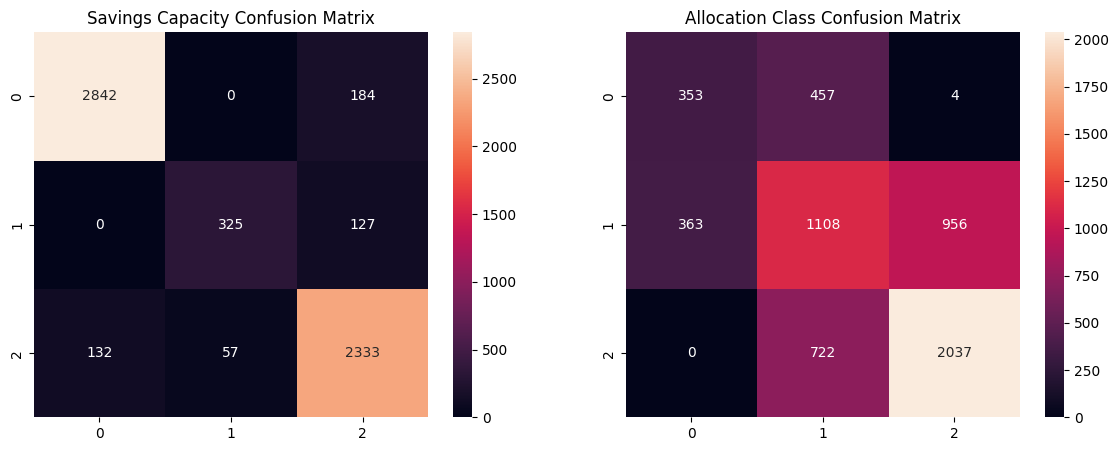

In [15]:
# ============================================
# CELL 11: CONFUSION MATRICES
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test_sav_dec, y_pred_sav_dec),
            annot=True, fmt='d', ax=axes[0])
axes[0].set_title("Savings Capacity Confusion Matrix")

sns.heatmap(confusion_matrix(y_test_alloc_dec, y_pred_alloc_dec),
            annot=True, fmt='d', ax=axes[1])
axes[1].set_title("Allocation Class Confusion Matrix")

plt.show()


In [ ]:
# ============================================
# CELL 12: EXPORT MODELS
# =========================================b===

import joblib
joblib.dump(pipeline_savings, "saving_capacity_model.pkl")
joblib.dump(pipeline_allocation, "risk_profile_model.pkl")
joblib.dump(le_savings, "le_savings.pkl")
joblib.dump(le_allocation, "le_allocation.pkl")


test = pd.DataFrame([{
    "Income": 75000,
    "Age": 24,
    "Dependents": 0,
    "Occupation": "Private",
    "City_Tier": "Tier_1",
    "Rent": 18000,
    "Loan_Repayment": 5000,
    "Insurance": 2000,
    "Groceries": 6000,
    "Transport": 3000,
    "Eating_Out": 4000,
    "Entertainment": 2500,
    "Utilities": 1800,
    "Healthcare": 1200,
    "Education": 0,
    "Miscellaneous": 1500
}])

risk_factor_enc = pipeline_allocation.predict(test)
saving_capacity_enc = pipeline_savings.predict(test)
print(le_allocation.inverse_transform(risk_factor_enc)[0])
print(le_savings.inverse_transform(saving_capacity_enc)[0])

balanced
high


In [25]:
import sklearn
print(sklearn.__version__)

1.6.0


In [26]:
import xgboost
print(xgboost.__version__)

3.0.4
